In [22]:
import os
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.translate import bleu_score

from euskalToken import EuskalToken

import warnings
warnings.filterwarnings("ignore")

def avg_of_sentence_bleu_scores(groundtruth_filename, prediction_filename, language):
    
    list_of_scores = []
    
    if language == "euskara":
        tokenize = EuskalToken().tokenize
    elif language == "english":
        tokenize = word_tokenize
            
    with open(groundtruth_filename, encoding="utf8") as gtfile, open(prediction_filename, encoding="utf8") as predfile:
   
        for i, (gt_sentence, predicted_sentence) in enumerate(zip(gtfile, predfile)):   
        
            gt_list_of_tokens = tokenize(gt_sentence)
            predicted_list_of_tokens = predicted_sentence.split()

            list_of_scores.append(bleu_score.sentence_bleu([gt_list_of_tokens], predicted_list_of_tokens))
            
        array_of_scores = np.asarray(list_of_scores)
        avg_bleu_scores = array_of_scores.mean()
          
    return avg_bleu_scores


In [2]:
groundtruth_filename = "./evaldata/berriak.en"
prediction_filename = "./predictions/predicted_berriak.unsup.en"

# Without smoothing
score = avg_of_sentence_bleu_scores(groundtruth_filename, prediction_filename, "english")
print("Non smoothed BLEU score: {:.2%}".format(score))

Non smoothed BLEU score: 0.14%


In [3]:
groundtruth_filename = "./evaldata/berriak.en"
prediction_filename = "./predictions/predicted_berriak.semisup.en"

# Without smoothing
score = avg_of_sentence_bleu_scores(groundtruth_filename, prediction_filename, "english")
print("Non smoothed BLEU score: {:.2%}".format(score))

Non smoothed BLEU score: 0.48%


In [4]:
groundtruth_filename = "./evaldata/berriak.eu"
prediction_filename = "./predictions/predicted_berriak.unsup.eu"

# Without smoothing
score = avg_of_sentence_bleu_scores(groundtruth_filename, prediction_filename, "euskara")
print("Non smoothed BLEU score: {:.2%}".format(score))

Non smoothed BLEU score: 0.03%


In [5]:
groundtruth_filename = "./evaldata/berriak.eu"
prediction_filename = "./predictions/predicted_berriak.semisup.eu"

# Without smoothing
score = avg_of_sentence_bleu_scores(groundtruth_filename, prediction_filename, "euskara")
print("Non smoothed BLEU score: {:.2%}".format(score))

Non smoothed BLEU score: 0.17%


In [23]:
import io

embeddings_handler = io.open("train_vocab.eu", 'r', encoding='utf-8', newline='\n', errors='ignore')

n, d = map(int, embeddings_handler.readline().split())
print("Found {} embeddings with dimension {}".format(n, d))

vocab = []

for line in embeddings_handler:
    tokens = line.rstrip().split(' ')
    vocab.append(tokens[0])
    
print(len(vocab))

Found 55333 embeddings with dimension 300
55333


In [24]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]
        
def compute_oov(lines, vocab):
    calc_oov = []
    
    for line in lines:
        tokens = line.rstrip().split()
        num_oov = 0.
        
        for token in tokens:
            if token not in vocab:
                num_oov += 1
                
        calc_oov.append(num_oov/len(tokens))
        
    return calc_oov

def filter_oov(lines, vocab):
    filtered = []
    
    for line in lines:
        tokens = line.rstrip().split()
        num_oov = 0.
        
        for token in tokens:
            if token not in vocab:
                num_oov += 1
                
        if num_oov/len(tokens) <= 0.1:
            filtered.append(line)
        
    return filtered

In [25]:
import math
import concurrent.futures
from itertools import repeat

total = 0
perc_oov = []

# Sentences have already been tokenized
with open("sentences.eu", "r") as f:
    sentences = f.readlines()
    
num_chunks = 1000
chunked_sentences = chunks(sentences, num_chunks)
vocab_repeated = repeat(vocab, math.ceil(len(sentences)/num_chunks))
oov_stats = []    
    
with concurrent.futures.ProcessPoolExecutor() as executor:
    for updated_sents in executor.map(compute_oov, chunked_sentences, vocab_repeated):
        oov_stats.extend(updated_sents)
        
        if len(oov_stats) % 100000 == 0:
            print("Processed {} sentences".format(len(oov_stats)))

Processed 100000 sentences
Processed 200000 sentences
Processed 300000 sentences
Processed 400000 sentences
Processed 500000 sentences
Processed 600000 sentences
Processed 700000 sentences
Processed 800000 sentences
Processed 900000 sentences
Processed 1000000 sentences
Processed 1100000 sentences
Processed 1200000 sentences
Processed 1300000 sentences
Processed 1400000 sentences
Processed 1500000 sentences
Processed 1600000 sentences
Processed 1700000 sentences
Processed 1800000 sentences
Processed 1900000 sentences
Processed 2000000 sentences
Processed 2100000 sentences
Processed 2200000 sentences
Processed 2300000 sentences
Processed 2400000 sentences


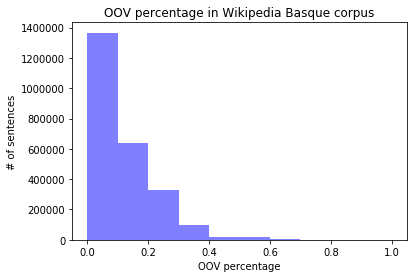

In [26]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

n, bins, patches = plt.hist(oov_stats, 10, facecolor='blue', alpha=0.5)
plt.title("OOV percentage in Wikipedia Basque corpus")
plt.xlabel("OOV percentage")
plt.ylabel("# of sentences")
plt.show()

In [27]:
# Sentences have already been tokenized
with open("parallel_sents.eu.train", "r") as f:
    sentences = f.readlines()
    
num_chunks = 1000
chunked_sentences = chunks(sentences, num_chunks)
vocab_repeated = repeat(vocab, math.ceil(len(sentences)/num_chunks))
oov_stats_paco = []    
    
with concurrent.futures.ProcessPoolExecutor() as executor:
    for updated_sents in executor.map(compute_oov, chunked_sentences, vocab_repeated):
        oov_stats_paco.extend(updated_sents)
        
        if len(oov_stats_paco) % 100000 == 0:
            print("Processed {} sentences".format(len(oov_stats)))

Processed 2485520 sentences


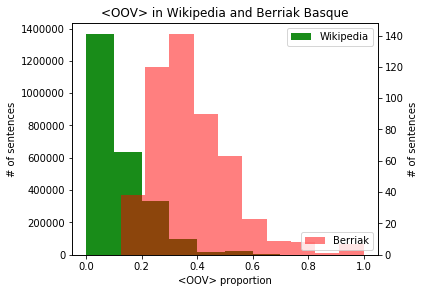

In [74]:
fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(oov_stats, 10, ls='dashed', alpha = 0.9, lw=3, color= 'g', label="Wikipedia")
ax2 = ax1.twinx()
n, bins, patches = ax2.hist(oov_stats_berriak, 10, ls='dotted', alpha = 0.5, lw=3, color= 'r', label="Berriak")
ax1.set_ylabel('# of sentences')
ax1.set_xlabel('<OOV> proportion')
ax2.set_ylabel('# of sentences')
ax2.tick_params('y')
fig.tight_layout()
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
ax1.set_title("<OOV> in Wikipedia and Berriak Basque")
plt.show()

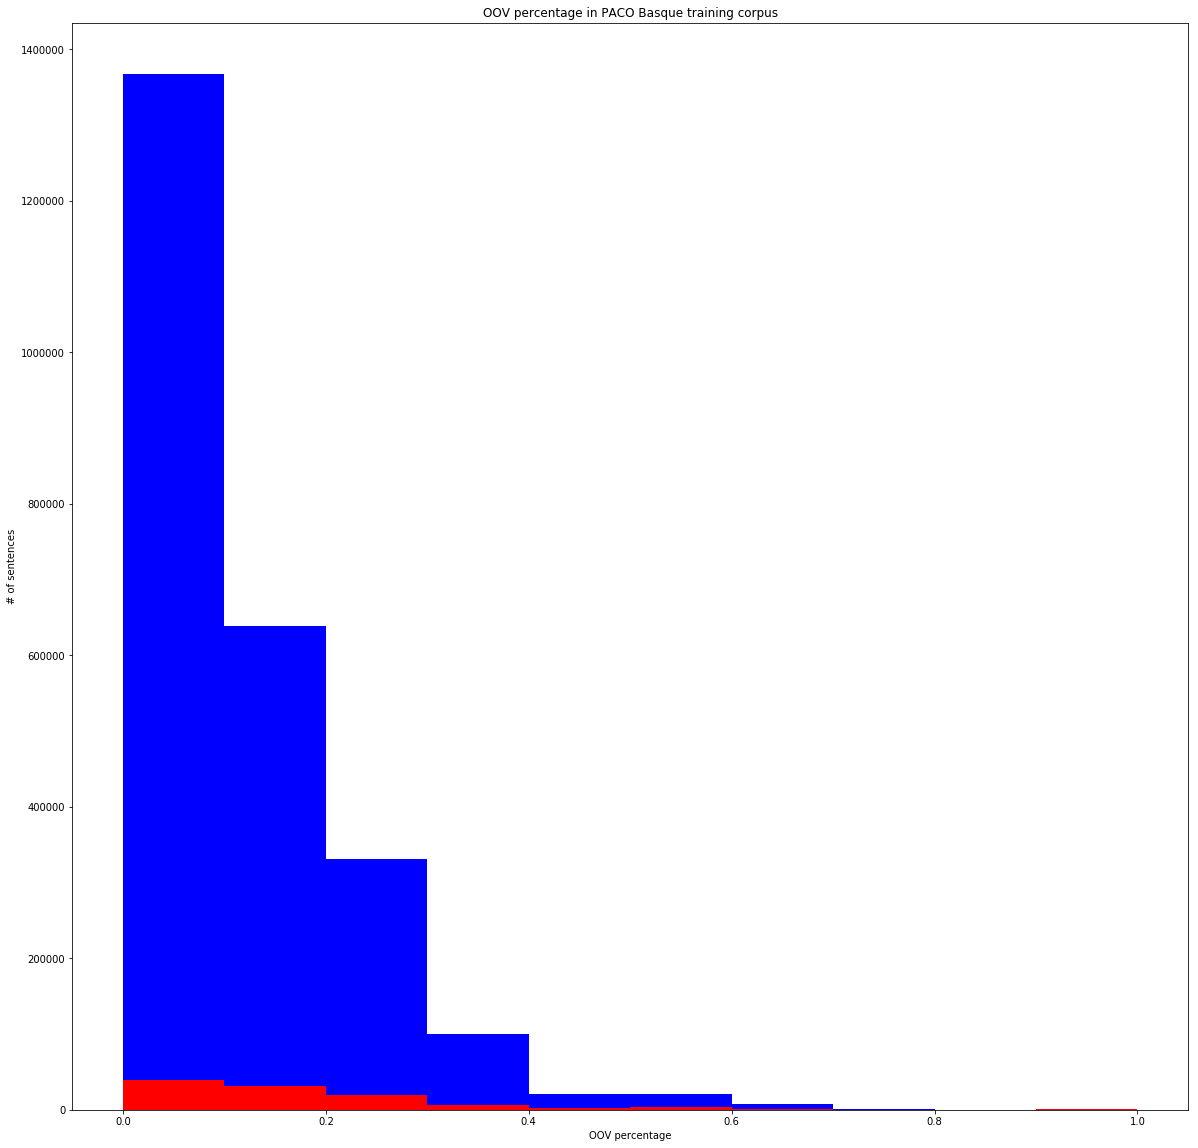

In [38]:
plt.figure(figsize=(20,20))
n, bins, patches = plt.hist(oov_stats, 10, facecolor='blue')
n, bins, patches = plt.hist(oov_stats_paco, 10, facecolor='red')
n, bins, patches = plt.hist(oov_stats_berriak, 10, facecolor='green')
plt.title("OOV percentage in PACO Basque training corpus")
plt.xlabel("OOV percentage")
plt.ylabel("# of sentences")
plt.show()

In [30]:
# Sentences have already been tokenized
with open("evaldata/berriak.eu", "r") as f:
    sentences = f.readlines()
    
num_chunks = 1000
chunked_sentences = chunks(sentences, num_chunks)
vocab_repeated = repeat(vocab, math.ceil(len(sentences)/num_chunks))
oov_stats_berriak = []    
    
with concurrent.futures.ProcessPoolExecutor() as executor:
    for updated_sents in executor.map(compute_oov, chunked_sentences, vocab_repeated):
        oov_stats_berriak.extend(updated_sents)
        
        if len(oov_stats_berriak) % 100000 == 0:
            print("Processed {} sentences".format(len(oov_stats_berriak)))

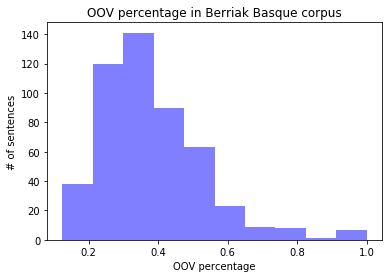

In [16]:
n, bins, patches = plt.hist(oov_stats, 10, facecolor='blue', alpha=0.5)
plt.title("OOV percentage in Berriak Basque corpus")
plt.xlabel("OOV percentage")
plt.ylabel("# of sentences")
plt.show()

In [19]:
with open("all_sentences.eu", "r") as f:
    sentences = f.readlines()
    
num_chunks = 1000
chunked_sentences = chunks(sentences, num_chunks)
vocab_repeated = repeat(vocab, math.ceil(len(sentences)/num_chunks))
result = []    
    
with concurrent.futures.ProcessPoolExecutor() as executor:
    for updated_sents in executor.map(filter_oov, chunked_sentences, vocab_repeated):
        result.extend(updated_sents)
        
        if len(result) % 100000 == 0:
            print("Processed {} sentences".format(len(result)))

In [22]:
with open("clean_mono.eu", 'w') as file:
    file.writelines("%s" % line for line in result)